## PROBLEM STATEMENT
* Important questions: 
who is the data far, the analysis is for who, what is the business impact and what is the main objective/outcome who is the data for
- investor: which companies should i invest in (smtht that aligns with my esg interest)
- regulator: 
- leadership team: 

## 5 plots:
- sectors with bottom 5 total esg risk score (then plot histogram for the narrowed down sectors)
- for each individual sector which is the main risk score causing the total risk score it to be low - env/social/gov risk score which is the main contributor 
--> drill down to company and which companies have the lowest esg risk score
--> what are some of the reasons for it - drill down into industry, nature of industry etc. some insights 
- try to find the associations between controversy levels and risk levels
- from top 5 sectors with lowest controversy risk level - based on composition -->


In [134]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from scipy.stats import gaussian_kde
from plotly.subplots import make_subplots
import seaborn as sns



In [ ]:
#df2: risk ratings of US companies based on esg scores
df2 = pd.read_csv('datasets/SP_500_ESG_Risk_Ratings.csv')
print(df2.head())
print(df2.info())


  Symbol                      Name  \
0   ENPH      Enphase Energy, Inc.   
1    EMN  Eastman Chemical Company   
2    DPZ       Domino's Pizza Inc.   
3    DAY            Dayforce, Inc.   
4    DVA               Davita Inc.   

                                             Address             Sector  \
0  47281 Bayside Parkway\r\nFremont, CA 94538\r\n...         Technology   
1  200 South Wilcox Drive\r\nKingsport, TN 37662\...    Basic Materials   
2  30 Frank Lloyd Wright Drive\r\nAnn Arbor, MI 4...  Consumer Cyclical   
3  3311 East Old Shakopee Road\r\nMinneapolis, MN...         Technology   
4  2000 16th Street\r\nDenver, CO 80202\r\nUnited...         Healthcare   

                  Industry Full Time Employees  \
0                    Solar               3,157   
1      Specialty Chemicals              14,000   
2              Restaurants               6,500   
3   Software - Application               9,084   
4  Medical Care Facilities              70,000   

                   

In [ ]:
#Data Summary Statistics for df2

def compute_summary_statistics(df):
    # Select numerical and categorical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    # Compute summary statistics
    num_summary = df[num_cols].describe().T  # Transpose for better readability
    # Display results
    print("Numerical Columns Summary:")
    print(num_summary)
   
compute_summary_statistics(df2)

Numerical Columns Summary:
                        count       mean       std  min   25%    50%     75%  \
Total ESG Risk score    430.0  21.533721  6.889176  7.1  16.4  21.05  26.000   
Environment Risk Score  430.0   5.739767  5.092421  0.0   1.8   4.05   8.950   
Governance Risk Score   430.0   6.725116  2.208085  3.0   5.3   6.10   7.675   
Social Risk Score       430.0   9.070465  3.657924  0.8   6.7   8.90  11.200   
Controversy Score       403.0   2.007444  0.793283  1.0   1.0   2.00   2.000   

                         max  
Total ESG Risk score    41.7  
Environment Risk Score  25.0  
Governance Risk Score   19.4  
Social Risk Score       22.5  
Controversy Score        5.0  


In [106]:
#Clean 2nd Dataset First
df2_cleaned = df2.dropna(subset = ['Sector', 'Total ESG Risk score'])
print(df2_cleaned.info())

def inspect_data(data):
    return pd.DataFrame(
        {
        "column": data.columns,
        "dtype": data.dtypes.values,
        "instances": data.count().values,
        "unique": data.nunique(),
        "sum_null": data.isna().sum()

        }
    )

df2_info = inspect_data(df2_cleaned)
print(df2_info)

<class 'pandas.core.frame.DataFrame'>
Index: 430 entries, 1 to 502
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Symbol                  430 non-null    object 
 1   Name                    430 non-null    object 
 2   Address                 430 non-null    object 
 3   Sector                  430 non-null    object 
 4   Industry                430 non-null    object 
 5   Full Time Employees     426 non-null    object 
 6   Description             430 non-null    object 
 7   Total ESG Risk score    430 non-null    float64
 8   Environment Risk Score  430 non-null    float64
 9   Governance Risk Score   430 non-null    float64
 10  Social Risk Score       430 non-null    float64
 11  Controversy Level       430 non-null    object 
 12  Controversy Score       403 non-null    float64
 13  ESG Risk Percentile     430 non-null    object 
 14  ESG Risk Level          430 non-null    object 

# Insights for Investors


In [149]:
# Define category colors
category_colors = {
    "Total ESG Risk score": "#89ac46", 
    "Environment Risk Score": "#d3e671", 
    "Governance Risk Score": "#f8ed8c", 
    "Social Risk Score": "#ff8989"
}

custom_colors = {
    "High": "#f78e31",
    "Medium": "#fbb040",
    "Low": "#208b3a",
    "Moderate": "#cbdb47",
    "Medium" :"#cbdb47",
    "Severe": "#e83715",
    "Significant":"#f26b21",
    "None": "#fcec52",
    "Negligible": "#fcec52"
}

## ESG Risk Level Composition by Sectors

In [150]:
levels = df2_cleaned[['Controversy Level', 'ESG Risk Level', 'Sector']]
df_esg_lvl = levels.groupby(["Sector", "ESG Risk Level"]).size().reset_index(name="Count")
df_esg_lvl["Proportion"] = df_esg_lvl.groupby("Sector")["Count"].transform(lambda x: x / x.sum())
df_esg_lvl["ESG Risk Level"] = (df_esg_lvl["ESG Risk Level"].astype("category")).str.strip()

low_esg = df_esg_lvl[df_esg_lvl["ESG Risk Level"] == "Low"][["Sector", "Proportion"]]
sorted_sectors = low_esg.sort_values(by="Proportion", ascending=False)["Sector"].tolist()

def plot_esg_level():
    fig2 = px.bar(
        df_esg_lvl, 
        x="Sector", 
        y="Proportion",  # Use proportion instead of count
        color="ESG Risk Level", 
        title="Composition of ESG Risk Levels by Sector",
        barmode="stack",
        text=df_esg_lvl["Proportion"].apply(lambda x: f"{x:.0%}"),
        color_discrete_map=custom_colors,
        category_orders={"Sector": sorted_sectors,
                         "ESG Risk Level": ["Severe", "High", "Medium", "Low", "Negligible"]}
    )

    fig2.update_layout(
        width=1000,  
        height=600, 
        title_x=0.5, 
        title_y=0.9,
        margin=dict(l=100, r=100, t=100, b=100),  
        legend_title_text="ESG Risk Level"  
    )

    # Format y-axis as percentage
    fig2.update_yaxes(showgrid = False, tickformat=".0%", title="Percentage of Companies (%)")

    fig2.show()

plot_esg_level()

## Recommended Sectors:
Real Estate and Technology:
Demonstrate strong ESG performance with a high concentration of companies in the "Low" and "Negligible" risk categories

Conversely, sectors such as Energy and Utilities exhibit higher ESG risks, with a substantial portion of companies falling into the "High" and "Severe" risk levels. 

Suggests that investors should carefully consider the sector-specific ESG risks when making investment decisions, potentially favoring sectors with robust ESG profiles while exercising caution in sectors with higher inherent risks to minimise company vultnerabilities in terms of legal penalties, operational disruptions and reputational damange. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

esg_score_ind_sector = df2_cleaned[['Total ESG Risk score', 'Environment Risk Score', 'Governance Risk Score', 'Social Risk Score', 'ESG Risk Level', "Industry", "Sector"]]
category_order = ['Severe', 'High', 'Medium', 'Low', 'Negligible']

industry_options = ["All"] + sorted(esg_score_ind_sector["Industry"].dropna().unique().tolist())
sector_options = ["All"] + sorted(esg_score_ind_sector["Sector"].dropna().unique().tolist())

industry_filter = widgets.Dropdown(
    options=industry_options, 
    value="All",
    description="Industry:"
)

sector_filter = widgets.Dropdown(
    options=sector_options, 
    value="All",
    description="Sector:"
)
def update_plot(selected_industry, selected_sector): 
    plt.close()

    filtered_data = esg_score_ind_sector.copy()

    if selected_industry != "All":
        filtered_data = filtered_data[filtered_data["Industry"] == selected_industry]

    if selected_sector != "All":
        filtered_data = filtered_data[filtered_data["Sector"] == selected_sector]
    
    sns.pairplot(filtered_data, 
                hue = "ESG Risk Level",
                hue_order = category_order,
                palette = custom_colors, 
                diag_kind = "kde")

    plt.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.1)

    # Add a centralized title
    plt.suptitle("Scatter and Density Pairplot of Risk Scores by ESG Risk Level", 
                fontsize=16, y=1.0)

    plt.show()

widgets.interactive(update_plot, selected_industry=industry_filter, selected_sector=sector_filter)

interactive(children=(Dropdown(description='Industry:', options=('All', 'Advertising Agencies', 'Aerospace & D…

## Top 5 Sectors, Industries and Companies based on Average Total and Total ESG Risk Score


In [175]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive

# Select relevant columns for both sector and industry
esg_scores = df2_cleaned[["Sector", "Industry", "Name", "Total ESG Risk score", 
                          "Environment Risk Score", "Governance Risk Score", 
                          "Social Risk Score"]]

numeric_columns = ["Total ESG Risk score", "Environment Risk Score", "Governance Risk Score", "Social Risk Score"]
esg_scores.rename(columns = {"Name":"Company"}, inplace = True)

def plot_esg_scores(grouping_by='Sector'):
    
    grouped_data = esg_scores.groupby(grouping_by)[numeric_columns].mean().reset_index()
    top5_data = grouped_data.nsmallest(5, "Total ESG Risk score")
    # Reshape the data for stacked bar chart
    top5_data_long = pd.melt(top5_data, id_vars=[grouping_by], value_vars=numeric_columns,
                                var_name='Risk Category', value_name='Average Risk Score')

    # Create the stacked bar plot using plotly express
    fig = px.bar(
        top5_data_long, 
        x=top5_data_long[grouping_by], 
        y='Average Risk Score',
        color='Risk Category',
        title=f"Top 5 with the Lowest Average Total ESG Risk Scores",
        color_discrete_map=category_colors,
        labels={grouping_by: grouping_by.capitalize(), 'Average Risk Score': 'Average Risk Score'},
        category_orders={grouping_by: top5_data[grouping_by].tolist()},
        text='Average Risk Score'
    )

    # Update layout and annotations
    fig.update_traces(texttemplate='%{text:.2f}', textposition='inside', hoverinfo='x+y+text')
    fig.update_layout(
        barmode='stack', 
        xaxis_tickangle=-45,
        margin=dict(t=50, b=100, l=100, r=100),
        title=dict(x=0.5)
        )
    fig.update_yaxes(showgrid=False)

    fig.show()
    


# Create a widget for selecting between 'Sector','Industry' & 'Company'
esg_button = widgets.ToggleButtons(
    options=['Sector', 'Industry','Company'],
    description="Toggle between the buttons",
    disabled=False,
    button_style='',  
    tooltips=['View by Sector', 'View by Industry', 'View by Company']
)

interactive_plot = interactive(plot_esg_scores, grouping_by=esg_button)

display(interactive_plot)

C:\Users\alyss\AppData\Local\Temp\ipykernel_26068\806333204.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



interactive(children=(ToggleButtons(description='Toggle between the buttons', options=('Sector', 'Industry', '…

## Top 5 Sectors:
### Real Estate, Technology, Consumer Cyclical, Communication Services, Healthcare
## Top 5 Industries: 
### Leisure, Auto Parts, Auto & Truck Dealership, Home Improvement Retail, REIT - Industrial
## Top 5 Companies: 
### Hasbro, Inc, Keysight Technologies, Cbre Group, Inc. , Cdw Corporation, Accenture Pic
- Table of Companies filtered by Industry with the Lowest ESG Ratings 

In [ ]:
# Select relevant columns for both sector and industry
esg_scores_2 = df2_cleaned[["Sector", "Industry", "Name", "Total ESG Risk score", 
                          "Environment Risk Score", "Governance Risk Score", 
                          "Social Risk Score", "Full Time Employees", "ESG Risk Level"]]  # Assuming 'ESG Risk Level' is present

# Rename 'Name' column to 'Company' for clarity
esg_scores_2.rename(columns={"Name": "Company"}, inplace=True)

def extract_top_5_companies_per_top_5_industries():
    # Step 1: Group by Industry and calculate the average 'Total ESG Risk score'
    industry_avg_risk = esg_scores_2.groupby("Industry")["Total ESG Risk score"].mean().reset_index()
    
    # Step 2: Get the Top 5 Industries based on the average Total ESG Risk Score
    top_5_industries = industry_avg_risk.nsmallest(5, "Total ESG Risk score")["Industry"].tolist()
    # Step 3: Filter the dataset to include only the rows for the Top 5 Industries
    esg_scores_2_filtered = esg_scores_2[esg_scores_2["Industry"].isin(top_5_industries)]
    # Step 4: For each of the Top 5 Industries, get the Top 5 Companies based on Total ESG Risk Score
    top_5_companies_per_industry = esg_scores_2_filtered.groupby("Industry").apply(
        lambda x: x.nsmallest(5, "Total ESG Risk score")
    ).reset_index(drop=True)

    
    return top_5_companies_per_industry

top_companies_table = extract_top_5_companies_per_top_5_industries()
top_companies_table

C:\Users\alyss\AppData\Local\Temp\ipykernel_26068\2976004748.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alyss\AppData\Local\Temp\ipykernel_26068\2976004748.py:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Sector,Industry,Company,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Full Time Employees,ESG Risk Level
0,Consumer Cyclical,Auto & Truck Dealerships,Carmax Inc.,12.1,0.1,4.0,8.0,"29,836",Low
1,Consumer Cyclical,Auto Parts,Aptiv Plc,10.7,1.5,5.3,3.9,"154,000",Low
2,Consumer Cyclical,Auto Parts,Lkq Corporation,11.1,3.8,3.3,4.0,"49,000",Low
3,Consumer Cyclical,Auto Parts,Borgwarner Inc.,12.6,2.7,5.7,4.2,"39,900",Low
4,Consumer Cyclical,Auto Parts,Genuine Parts Company,13.7,4.7,3.8,5.2,"60,000",Low
5,Consumer Cyclical,Home Improvement Retail,Lowe's Companies Inc.,11.8,3.3,3.2,5.3,"300,000",Low
6,Consumer Cyclical,Home Improvement Retail,"Home Depot, Inc.",12.6,3.3,3.8,5.6,"465,000",Low
7,Consumer Cyclical,Leisure,"Hasbro, Inc.",7.1,0.0,4.2,2.9,"5,502",Negligible
8,Real Estate,REIT - Industrial,"Prologis, Inc.",10.3,2.7,5.0,2.5,"2,574",Low
9,Real Estate,REIT - Industrial,Public Storage,13.1,4.7,5.7,2.6,"6,200",Low


In [167]:
top_sectors = df2_cleaned.groupby('Sector')[numeric_columns].mean().reset_index()\
    .nsmallest(5, "Total ESG Risk score")['Sector'].tolist()

esg_scores_filtered_a = df2_cleaned[df2_cleaned['Sector'].isin(top_sectors)]
esg_scores_filtered_b = esg_scores_filtered_a[['Total ESG Risk score', 'Environment Risk Score', 'Governance Risk Score', 'Social Risk Score', 'ESG Risk Level']]


# Melt the dataframe
esg_long = esg_scores_filtered_b.melt(id_vars=["ESG Risk Level"], var_name="ESG Category", value_name="Score")
esg_long["ESG Category"] = esg_long["ESG Category"].astype("category")


def plot_histogram():
    # Prepare the data in long format for easier plotting with facet_row
    esg_long['ESG Category'] = esg_long['ESG Category'].str.strip()  

    # Create the histogram and median lines using Plotly Express with facet_row
    fig = px.histogram(
        esg_long, 
        x="Score", 
        color="ESG Category",  
        facet_col="ESG Category",  
        nbins=25,
        opacity=0.7, 
        title="Distribution of ESG Scores by Category for Top 5 Sectors", 
        color_discrete_map=category_colors,
        labels={"Score": "ESG Score", "percent": "Percentage of Scores"}
    )

    # Add median lines for each category
    for col in esg_scores_filtered_b.columns[:-1]:
        data = esg_long[esg_long['ESG Category'] == col]['Score']
        
        # Calculate median
        median = data.median()
    

        # Add median line to the histogram
        fig.add_vline(
            x=median, 
            line=dict(color="blue", width=2, dash="dot"), 
            annotation_text=f"Median: {median:.2f}", 
            annotation_position="top right",
            col=esg_scores_filtered_b.columns.tolist().index(col) + 1, 
            opacity=0.6
        )
    
    # Update layout settings
    fig.update_layout(
        height=600,  
        width=1200,
        showlegend=False,
        title_font_size=20,  
        title_x=0.5,
        font=dict(family="Arial", size=12, color="black"),
        bargap=0.1
    )

    fig.update_xaxes(matches=None)  # Set independent x-axes
    fig.update_yaxes(matches=None)  # Set independent y-axes
    
    # Remove gridlines and adjust axes
    fig.update_yaxes(showticklabels=True, title_text="Percentage of Scores", row=1, col=1)
    fig.update_xaxes(showgrid=False, title_text="ESG Score", row=1, col=1)
    
    fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1] if '=' in a.text else a.text))

    # Show plot
    fig.show()

def plot_density_by_sector():
    # Get the unique top 5 sectors
    sectors = esg_scores_filtered_a['Sector'].unique()
    num_sectors = len(sectors)

    # Define ESG categories
    esg_categories = ["Environment Risk Score", "Governance Risk Score", "Social Risk Score", "Total ESG Risk score"]

    # Create a 3-row x 2-column grid (for max 6 plots)
    fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    for i, sector in enumerate(sectors):
        ax = axes[i]

        # Filter data for the current sector
        sector_data = esg_scores_filtered_a[esg_scores_filtered_a["Sector"] == sector]
        
        # Plot density for each ESG category
        for category in esg_categories:
            sns.kdeplot(sector_data[category], ax=ax, 
                        label=category, 
                        color=category_colors.get(category, np.random.choice(["blue", "green", "red"])), 
                        fill=True)

        # Formatting
        ax.set_title(sector, fontsize=14)
        ax.set_xlabel("ESG Score", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        ax.tick_params(axis="both", labelsize=10)
        ax.legend(fontsize=10)

    # Hide the last empty subplot if there are fewer than 6 sectors
    if num_sectors < 6:
        for j in range(num_sectors, 6):
            fig.delaxes(axes[j])

    plt.suptitle("Density Distribution of ESG Scores by Sector", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix():
    correlation_matrix = esg_scores_filtered_b[['Total ESG Risk score', 'Environment Risk Score', 'Governance Risk Score', 'Social Risk Score']].corr()

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Between ESG Risk Components and Total ESG Risk Score", fontsize=14)
    plt.show()


# Insights for Regulators

## Key Insights based on Distribution of Risk Scores accross Companies in the Top 5 Sectors

### 1. Social Risk Dominance: 

The higher median and broader distribution of social risk scores suggest that social factors are a more significant driver of overall ESG risk compared to environmental and governance factors in these top 5 sectors.

### 2. Low Environmental Risk: 

The very low median and highly skewed distribution of environmental risk scores indicate that environmental risks are generally well-managed or inherently low in these sectors

### 3. Total ESG Risk Skew: 

The skew in the total ESG risk score towards higher values suggests that while many companies have relatively low overall risk, there are still a significant number with higher risks, likely driven by social and, to a lesser extent, governance factors

In [168]:
plot_histogram()

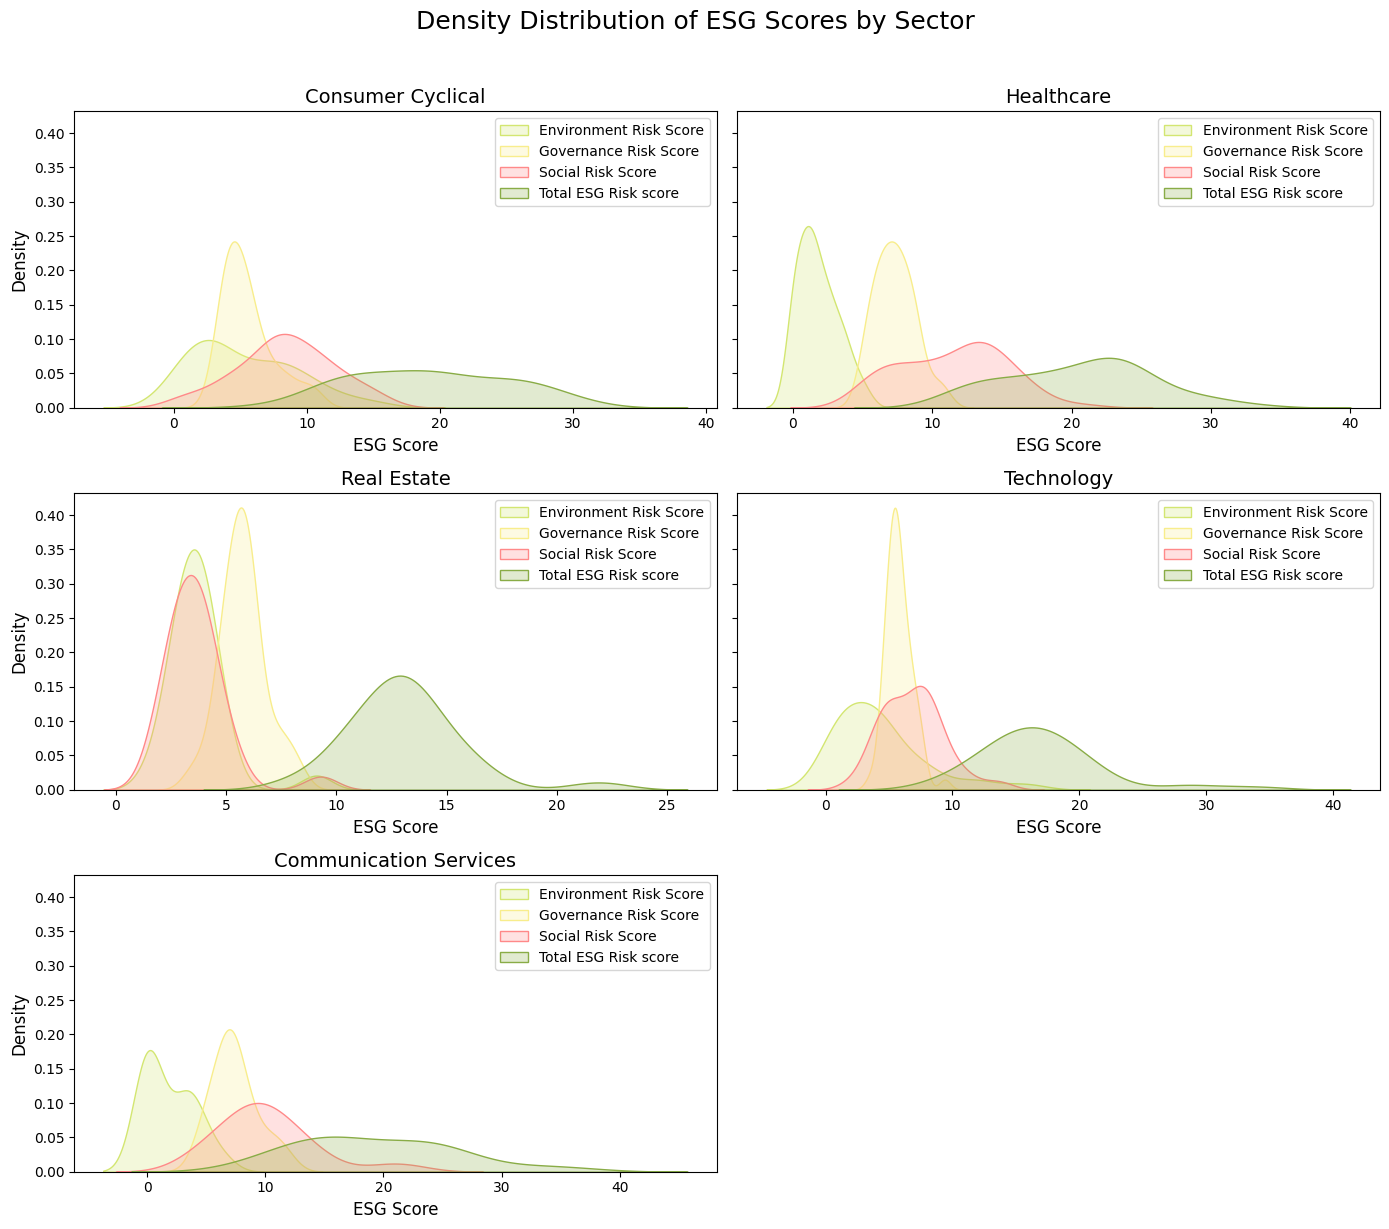

In [169]:
plot_density_by_sector()

## Main Insights from Density Distribution
### Real Estate, Technology, and Communication Services 
- show a similar pattern of low ESG risk, particularly in the environmental component, suggesting higher focus on environmental sentiments and more efforts put in place to maange environmental risks

### Healthcare and Consumer Cyclical sectors 
- exhibit more variability in their ESG scores particularly in the social and governance aspects

### Risk Distribution-Wise
Environmental risk tends to be lower across all sectors compared to social and governance risks. This might indicate that companies are generally more focused on addressing environmental concerns, or that environmental risks are more easily quantifiable and manageable

## Which ESG Risk Score Component contributes significantly to the Total Risk Score:

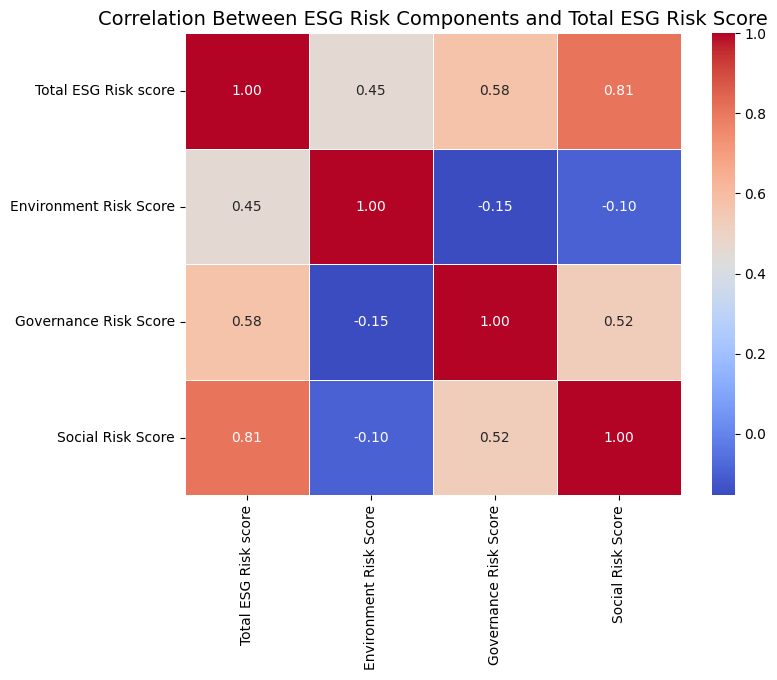

In [208]:
plot_correlation_matrix()

### Social Risk Score: 0.81 (Strong positive correlation) 
- This shows a strong positive correlation, indicating that social risk is a major driver of the overall ESG risk score.

### Governance Risk Score: 0.58 (Moderate positive correlation) 
- Similar to environmental risk, higher governance risk is associated with higher total ESG risk, but the relationship is moderately strong.

## Key Correlation Insight Among Individual Componenents 
Governance vs. Social: 0.52 (Moderate positive correlation) 
- There's a moderate tendency for companies with higher governance risk to also have higher social risk.

# Key takeaways: Stronger emphasis on Social risk management to improve overall ESG ratings 
### Tips for Companies
- Invest in employee training and development 
- Enhance customer relations, strengthen community relations

# Key Insights for Stakeholders

In [166]:
#bar charts of risk and controvery levels
import ipywidgets as widgets
from IPython.display import display, clear_output
levels = df2_cleaned[['Controversy Level', 'ESG Risk Level', 'Sector']]

# Remove "Controversy Level=" from values in the column
levels["Controversy Level"] = levels["Controversy Level"].str.replace("Controversy Level", "", regex=False)
df_controversy_lvl = levels.groupby(["Sector", "Controversy Level"]).size().reset_index(name="Count")
df_controversy_lvl["Proportion"] = df_controversy_lvl.groupby("Sector")["Count"].transform(lambda x: x / x.sum())
df_controversy_lvl["Controversy Level"] = (df_controversy_lvl["Controversy Level"].astype("category")).str.replace("Controversy Level", "", regex=False).str.strip()

low_controversy = df_controversy_lvl[df_controversy_lvl["Controversy Level"] == "Low"][["Sector", "Proportion"]]
sorted_sectors = low_controversy.sort_values(by="Proportion", ascending=True)["Sector"].tolist()

def plot_controversy_level():
    fig1 = px.bar(
        df_controversy_lvl, 
        x="Sector", 
        y="Proportion",  # Use proportion instead of count
        color="Controversy Level", 
        title="Composition of Controversy Levels by Sector",
        barmode="stack",
        text=df_controversy_lvl["Proportion"].apply(lambda x: f"{x:.0%}"),
        color_discrete_map=custom_colors,
        category_orders={"Sector": sorted_sectors,
            "Controversy Level": ["Severe", "Significant", "High", "Moderate", "Low", "None"]}
    )

    fig1.update_layout(
        width=1000,  
        height=600, 
        title_x=0.5, 
        title_y=0.9,
        margin=dict(l=100, r=100, t=100, b=100),  
        legend_title_text="Controversy Level"  
    )

    # Format y-axis as percentage
    fig1.update_yaxes(showgrid = False, tickformat=".0%", title="Percentage of Companies")

    fig1.show()

plot_controversy_level()

C:\Users\alyss\AppData\Local\Temp\ipykernel_26068\3755112071.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Sectors with Higher Concentration of Companies with Significatn Controversy Level
Consumer Defensive, 

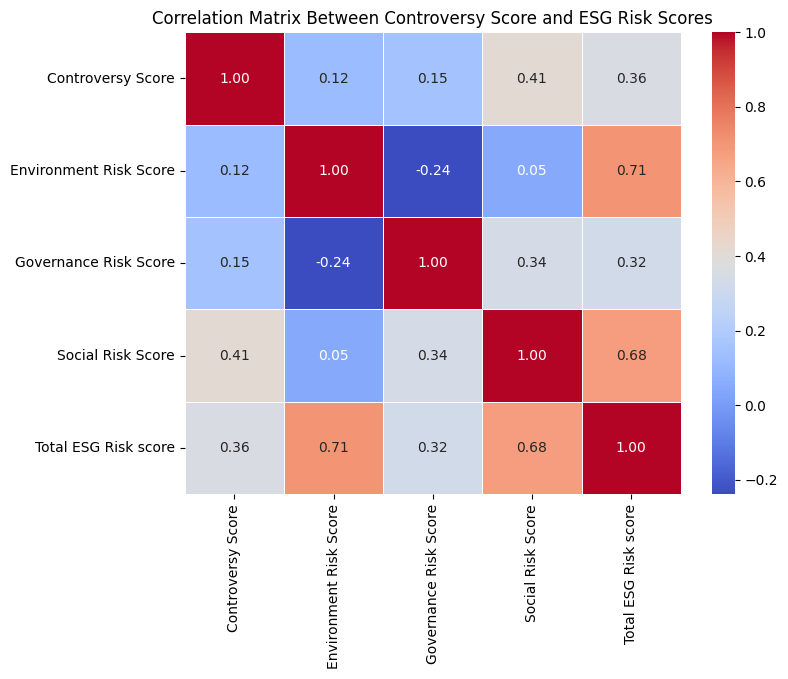

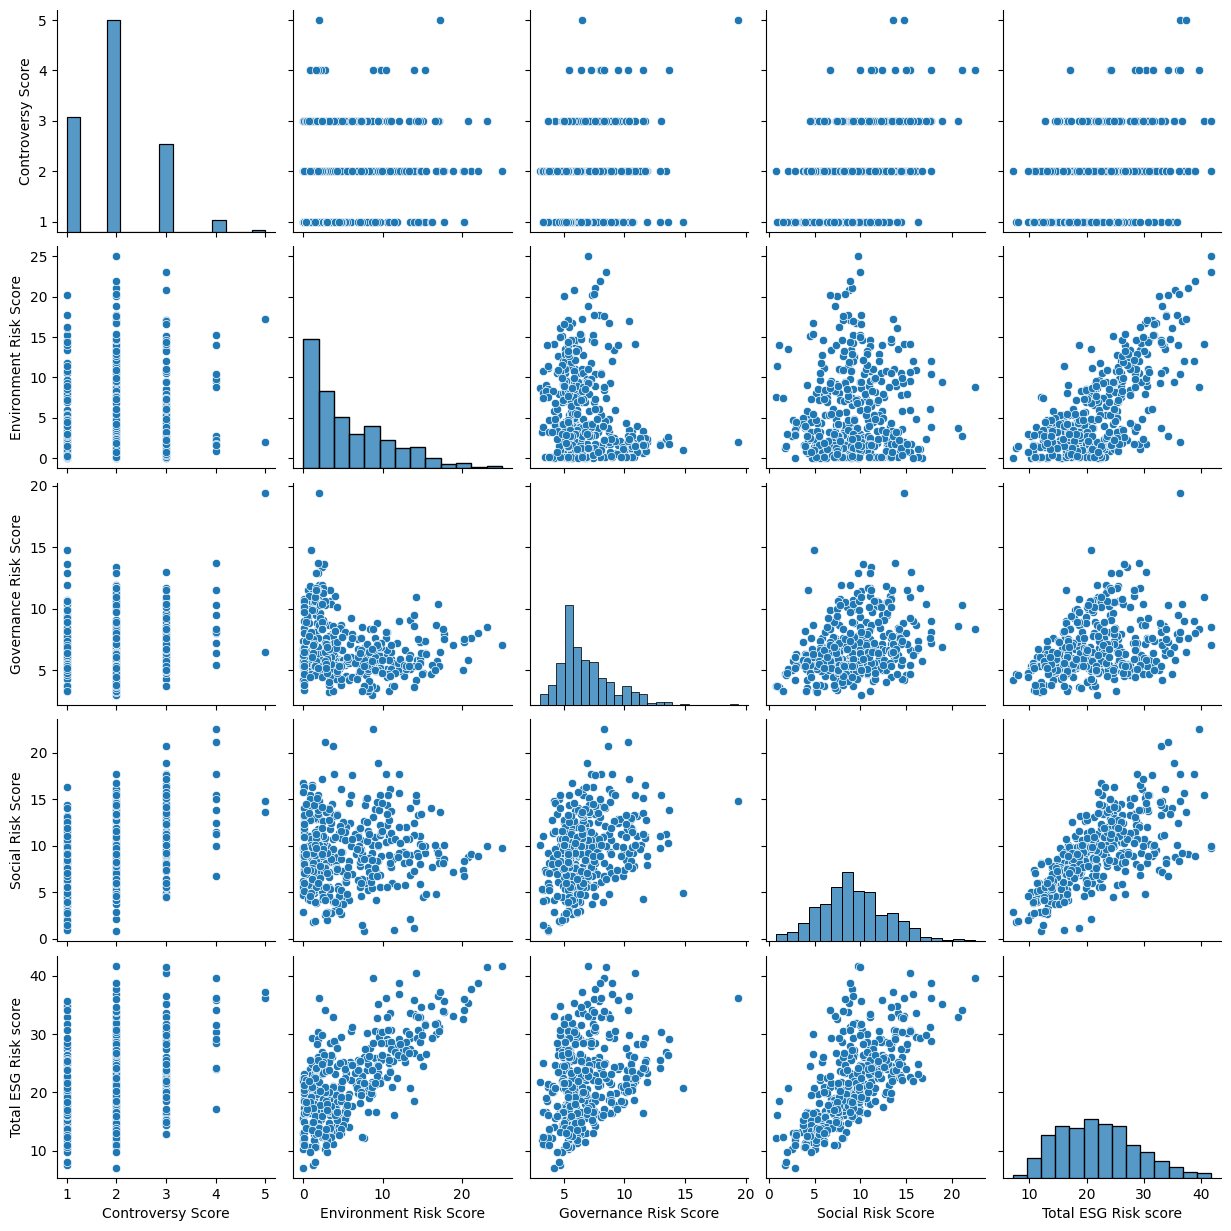

In [210]:
# Select relevant columns for controversy score and ESG risk scores
columns_of_interest = ['Controversy Score', 'Environment Risk Score', 'Governance Risk Score', 'Social Risk Score', 'Total ESG Risk score']

# Subset the dataframe to the columns of interest
df_correlate = df2_cleaned[columns_of_interest]


# Drop rows with missing values (if any)
df_correlate_cleaned = df_correlate.dropna()

# Compute Pearson correlation matrix
correlation_matrix = df_correlate_cleaned.corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Between Controversy Score and ESG Risk Scores")
plt.show()

# Scatter plot of Controversy Score vs. ESG Risk Scores
sns.pairplot(df_correlate_cleaned, kind="scatter")
plt.show()



## 

In [ ]:
significant_controversy = df2_cleaned[df2_cleaned['Controversy Level'] == 'Significant']

# Group by sector and calculate the proportion of significant controversy
sector_controversy_proportion = significant_controversy.groupby('Sector').size() / df2_cleaned.groupby('Sector').size()

# Get top 5 sectors with the highest proportion of significant controversy
top_5_sectors = sector_controversy_proportion.nlargest(5).index.tolist()

# Step 2: For each of these top 5 sectors, calculate the average Total ESG Risk score for industries within those sectors
df_top_sectors = df2_cleaned[df2_cleaned['Sector'].isin(top_5_sectors)]
industry_avg_esg = df_top_sectors.groupby(['Sector', 'Industry'])['Total ESG Risk score'].mean().reset_index()

# Step 3: Plot the bar chart of industries within top 5 sectors and their respective average Total ESG Risk scores
fig = px.bar(industry_avg_esg,
             x='Industry',
             y='Total ESG Risk score',
             color='Sector',
             title="Average Total ESG Risk Scores by Industry in Top 5 Sectors witH Companies ",
             labels={'Total ESG Risk score': 'Average Total ESG Risk Score'},
             color_discrete_sequence=px.colors.qualitative.Set1)

# Sorting industries by Sector
fig.update_layout(
    xaxis_tickangle=-45,
    barmode='group',
    xaxis={'categoryorder': 'array', 'categoryarray': industry_avg_esg['Sector'].unique()},
    margin=dict(t=50, b=150, l=100, r=100),
    title=dict(x=0.5)
)

fig.show()

In [ ]:

data = df2_cleaned[["Full Time Employees", "ESG Risk Percentile"]]
data = data[data["Full Time Employees"].astype(str) != "NA"]
data["Full Time Employees"] = data["Full Time Employees"].astype(str).str.replace(",", "").astype(float)


bins = [0, 1000, 5000, 10000, 20000, 50000, 80000, 110000, 150000, 300000, 500000, float("inf")]
labels = ["0-1000", "1000 - 5000", "5000-10000", "10000-20000", "20000-50000", "50000-80000", "80000-110000", "110000-150000", "150000-300000", "300000-500000", "500000+"]

data["Company Size Category"] = pd.cut(data["Full Time Employees"], bins=bins, labels=labels, right=False)
size_counts = data["Company Size Category"].value_counts().reset_index()
size_counts.columns = ["Company Size Category", "Count"]

size_counts["Company Size Category"] = pd.Categorical(size_counts["Company Size Category"], categories=labels, ordered=True)
size_counts = size_counts.sort_values("Company Size Category")

fig = px.bar(
    size_counts, 
    x="Company Size Category", 
    y="Count", 
    title="Distribution of Companies by Number of Employees",
    text=size_counts["Count"],  # Display count on bars
    color="Company Size Category",  # Use different colors for categories
    color_discrete_sequence=px.colors.qualitative.Set2  # Custom color palette
)

# Adjust layout
fig.update_traces(textposition="outside")  # Show text outside bars
fig.update_layout(
    xaxis_title="Company Size Category", 
    yaxis_title="Number of Companies",
    bargap=0.2,  # Space between bars
    width=800,  # Increase figure width
    height=500   # Increase figure height
)

fig.show()


